# Inference Sampling, sampling strategies
- The notebook visualizes the Recall metric at cutoffs [1,5,10,20] for different sampling techniques
- This shows how different sampling techniques approximate the no sampling method

In [1]:
# Before running the example notebook make sure to execute the following commands, to create the necessary datasets:
# ! python data/coveo_preproc.py -p data/data_sources/coveo_ecommerce
# ! python data/retailrocket_preproc.py -p data/data_sources/retailrocket_ecommerce
# ! python data/rees46_preproc.py -p data/data_sources/ress46_ecommerce

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import itertools
from collections import defaultdict

from utils.experiment_setup import gru4rec_sampling_setups as setups
from utils.gru4rec_train_test_utils import train_test_gru4rec_models 
from utils.plot_config import *
mpl.rc('lines', linewidth=plot_line_width)

In [3]:
experiments = {
    "coveo": {
        "train_path": "data/data_sources/coveo_ecommerce/coveo_processed_view_train_full.tsv",
        "test_path": "data/data_sources/coveo_ecommerce/coveo_processed_view_test.tsv",
        "methods": ["full", "closest", "farthest", "similar", "dissimilar", "uniform", "popular", "invpopular", "popstatic"],
        "model": "coveo_optuna_mrr_bprmax_constrained_fulltrain"
    },
    "retailrocket": {
        "train_path": "data/data_sources/retailrocket_ecommerce/retailrocket_processed_view_train_full.tsv",
        "test_path": "data/data_sources/retailrocket_ecommerce/retailrocket_processed_view_test.tsv",
        "methods": ["full", "closest", "farthest", "similar", "dissimilar", "uniform", "popular", "invpopular", "popstatic"],
        "model": "retailrocket_optuna_mrr_bprmax_constrained_fulltrain" 
    },
    "rees46": {
        "train_path": "data/data_sources/rees46_ecommerce/rees46_processed_view_train_full.tsv",
        "test_path": "data/data_sources/rees46_ecommerce/rees46_processed_view_test.tsv",
        "methods": ["full", "closest", "farthest", "similar", "dissimilar", "uniform", "popular", "invpopular", "popstatic"],
        "model": "rees46_optuna_mrr_xe_constrained_fulltrain"
    },
}
n_epochs = 5

### Training the models required for this experiment

In [4]:
exp = {}
for dataset_name, dataset_params in experiments.items():
    exp[dataset_name] = {"train_path": dataset_params["train_path"]}
train_test_gru4rec_models(experiments=exp, setups=setups, n_epochs=n_epochs, save_model=True)

SKIPPING training, model already exists: data/models/coveo_optuna_mrr_bprmax_constrained_fulltrain.pickle
SKIPPING training, model already exists: data/models/coveo_optuna_mrr_xe_noembed_fulltrain.pickle
SKIPPING training, model already exists: data/models/retailrocket_localsearch100_bprmax_constrained_fulltrain.pickle
SKIPPING training, model already exists: data/models/retailrocket_optuna_recall_xe_embed_fulltrain.pickle
SKIPPING training, model already exists: data/models/rees46_optuna_mrr_xe_noembed_fulltrain.pickle
SKIPPING training, model already exists: data/models/rees46_localsearch100_bprmax_embed_fulltrain.pickle
SKIPPING training, model already exists: data/models/rees46_localsearchbig_bprmax_constrained_fulltrain.pickle


### Using the trained models to measure Recall and MRR values for different negative sampling techniques
In this experiment the following techniques are used:
 "popular": "Popularity sampling", "uniform": "Uniform sampling", "invpopular": "Inverse popularity sampling"
- "All items" ("full")
    - No sampling is applied
- "Most similar" ("similar") / "Least similar" ("dissimilar")
    - For each item the most similar or lest similar 100 items are used as negative samples
    - Similarity is defined as the cosine similarity between the output embedding (Wy matrix of GRU4Rec) of target and every other item. Cosine similarity can take up values on the [-1,1] range. Values close to 1 means the embeddings are similar while values close to -1 means they are dissimilar.
- "Closest" ("closest") / "Farthest" ("farthest")
    - For each item the closest or farthest 100 items are used as negative samples
    - Closeness is defined as the euclidean distance between the output embedding (Wy matrix of GRU4Rec) of target and every other item. The closer they are the smaller the euclidean distance while the farther they are the larger the distance
- "Most popular" ("popstatic")
    - For each item the 100 most popular items are used as negative samples
- "Popularity sampling" ("popular") / "Inverse popularity sampling" ("invpopular")
    - For each item 100 negative items are chosen randomly, where the probability of an item being chosen is proportional / inversly prorportional to its popularity.
- "Uniform sampling" ("uniform")
    - 100 negative items are sampled randomly per target item


### Running inference sampling with GRU4Rec

In [5]:
for dataset_key, dataset_params in experiments.items():
    train_path =  dataset_params["train_path"]
    test_path =  dataset_params["test_path"]
    methods = dataset_params["methods"]
    model = dataset_params["model"]
    model_path = os.path.join("data", "models", model+".pickle")
    ret_code = os.system(f"conda run -n gru4rec_theano_gpu --no-capture-output THEANO_FLAGS='device=cuda0,dnn.enabled=False' python sampling/inference_sampling.py --train_path {train_path} --test_path {test_path} --model_path {model_path} --methods {' '.join(methods)}")
    if ret_code != 0: raise ValueError(f"process returned with code: {ret_code}") 

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda0: NVIDIA GeForce GTX TITAN X (0000:02:00.0)


Files already exist, SKIPPING:
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_full_recall.tsv
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_full_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_closest_recall.tsv
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_closest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_farthest_recall.tsv
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_farthest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_similar_recall.tsv
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_similar_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/coveo_optuna_mrr_bprmax_constrained_fulltrain_dissimilar_recall.tsv
dat

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda0: NVIDIA GeForce GTX TITAN X (0000:02:00.0)


Files already exist, SKIPPING:
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_full_recall.tsv
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_full_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_closest_recall.tsv
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_closest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_farthest_recall.tsv
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_farthest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_similar_recall.tsv
data/results/sampling_results/retailrocket_optuna_mrr_bprmax_constrained_fulltrain_similar_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/retailrocket_op

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda0: NVIDIA GeForce GTX TITAN X (0000:02:00.0)


Files already exist, SKIPPING:
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_full_recall.tsv
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_full_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_closest_recall.tsv
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_closest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_farthest_recall.tsv
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_farthest_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_similar_recall.tsv
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_similar_mrr.tsv
Files already exist, SKIPPING:
data/results/sampling_results/rees46_optuna_mrr_xe_constrained_fulltrain_dissimilar_recall.tsv
data/results/sampling_results/

In [6]:
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def format_plot(ax, make_legend):
    if make_legend:
        ncol = 5
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = flip(handles, ncol), flip(labels, ncol)
        ax.legend(handles, labels, loc="upper center", prop={'size': fontsize*1.3}, bbox_to_anchor=(0.5, -0.125), ncol=5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(plot_axis_line_width)
    ax.tick_params(width=plot_axis_line_width*2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize*1.2)
    ax.tick_params(axis='x', which='major', labelsize=fontsize*1.0, rotation=0)

In [7]:
def load_dataset_stats(dataset_names, dataset_methods, metric_n, metric):
    dataset_stats = defaultdict(dict)
    file_path = "./data/results/sampling_results"
    metric_file_names = os.listdir(file_path)
    for dataset_name, dataset_value in dataset_names.items():
        for method in dataset_methods.keys():
            curr_fn = f"{dataset_value}_{method}_{metric}"
            metric_file_name = next((fn for fn in metric_file_names if curr_fn in fn), None)
            if metric_file_name is None:
                raise ValueError(f"No matching {metric} or {method} file for dataset: {dataset_name}")
            data = pd.read_csv(os.path.join(file_path, metric_file_name), sep='\t')
            dataset_stats[dataset_name][method] = data.values.flatten()[np.array(metric_n)-1]
    return dataset_stats

In [8]:
def create_barplot(ax, labels, dataset_stats, dataset_methods, colormap, x_label, make_legend):
    x = np.arange(len(labels))
    width = 0.1
    multiplier = 0
    for i, (attribute, measurement) in enumerate(dataset_stats.items()):
        measurement = np.array(measurement)
        offset = width * multiplier
        lab = dataset_methods[attribute]
        ax.bar(x + offset, measurement, width, label=lab, color=colormap[i])
        multiplier += 1
    ax.set_xticks(x + 4*width, labels)
    ax.set_xlabel(x_label, fontsize=fontsize*1.4, labelpad=10)
    format_plot(ax, make_legend=make_legend)

In [9]:
dataset_names = {
    "Rees46": experiments["rees46"]["model"],
    "Coveo":experiments["coveo"]["model"],
    "Retailrocket": experiments["retailrocket"]["model"], 
    } 
dataset_methods = {"full": "All items", "similar": "Most similar", "closest": "Closest", "popstatic": "Most popular", "popular": "Popularity sampling", "uniform": "Uniform sampling", "invpopular": "Inverse popularity sampling", "farthest": "Farthest", "dissimilar": "Least similar"}
metric = "recall"
metric_n = [1,5,10,20]
recalls_labels = np.array([f"Recall@{n}" for n in metric_n])

In [10]:
cmap = np.array(mpl.colormaps['tab20c'](np.arange(8)))
oranges = cmap[4:8][::-1]
blues = np.repeat(np.array([[24, 82, 124]]), 4, axis=0)
blue_alphas = np.array([1.0,0.75,0.5,0.25]).reshape(-1,1)
blues = np.hstack([blues/255, blue_alphas])
cmap = np.vstack([blues, oranges])
cmap = np.vstack([np.array([0,0,0,1]), cmap])

In [11]:
dataset_stats = load_dataset_stats(dataset_names, dataset_methods, metric=metric, metric_n=metric_n)

### Recall@[1,5,10,20] for different sampling techniques
- While "Most similar" yields the best approximation of the true ranking, neither "Most similar" nor "Closest" can produce consistent good results, while being computationally expensive. 
- Popularity sampling and most popular items are better than uniform sampling, but these approaches are still not able to estimate the true rank of the target.
- Based on out experiments, there is no true alternative for full evaluation, and no other approach should be used during evaluation.


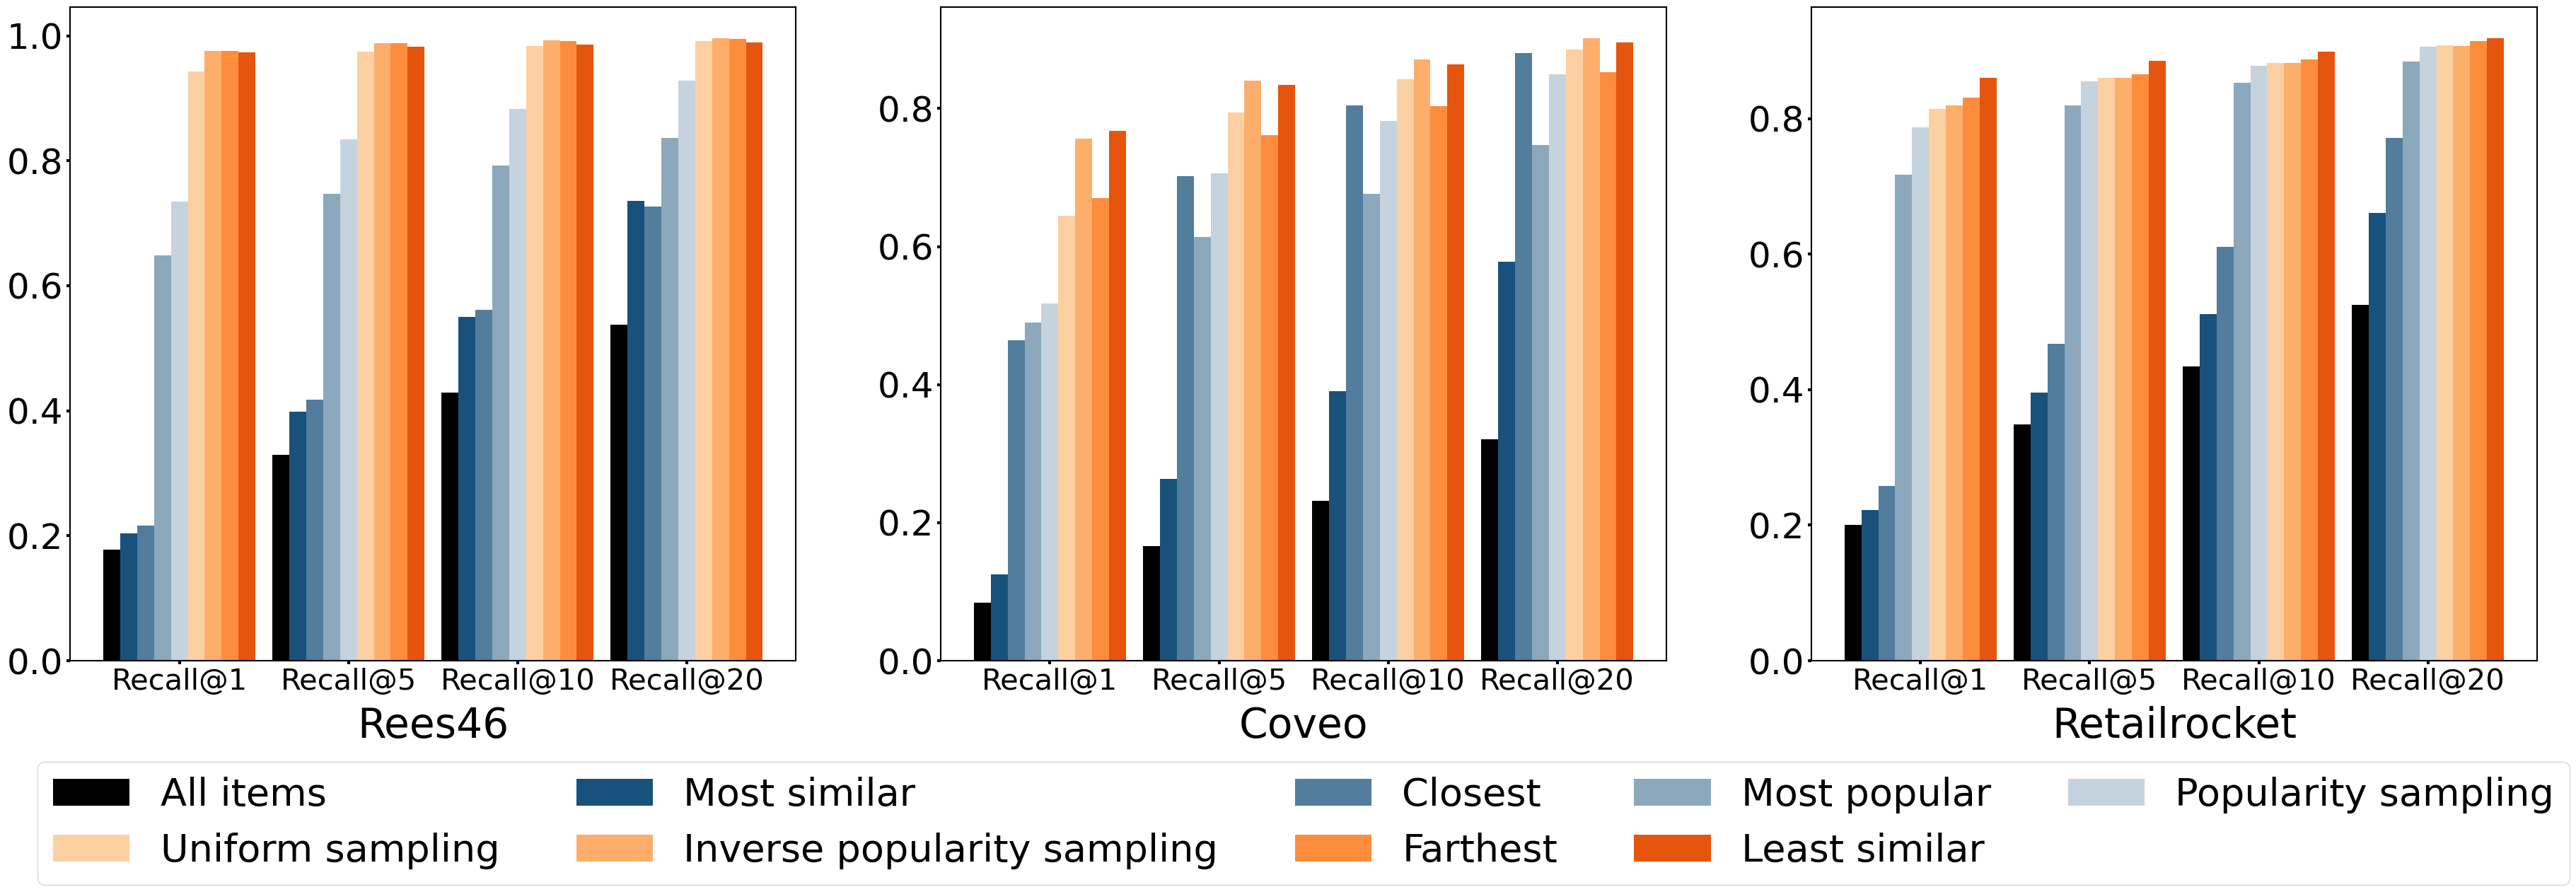

In [12]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(45,12))
for i, ds_name in enumerate(dataset_names.keys()):
    ax = axs[i] 
    create_barplot(ax, labels=recalls_labels, dataset_stats=dataset_stats[ds_name], dataset_methods=dataset_methods, colormap=cmap, x_label=ds_name, make_legend=True if i == 1 else False)